In [1]:
using Revise
using LinearAlgebra
using Statistics
using YAML
includet("utils.jl")
config_dict = YAML.load_file("../experiment_config.yml")

Dict{Any, Any} with 12 entries:
  "y_var_names"   => ["clwvi", "clvi", "dsevi", "husvi", "hurvi", "rlut", "rlut…
  "prior"         => "prior.toml"
  "batch_size"    => 1
  "output_dir"    => "output/local_calibration"
  "g_t_start_sec" => 144000.0
  "g_t_end_sec"   => 288000.0
  "ensemble_size" => 100
  "noise"         => "obs_noise_cov.jld2"
  "observations"  => "observations.jld2"
  "n_iterations"  => 10
  "model_config"  => "model_config.yml"
  "dims"          => 9

In [4]:
pwd()

"/central/home/jschmitt/ClimaAtmos.jl/calibration/experiments/local_calibration/post_processing"

In [9]:
eki = JLD2.load_object("../output/local_calibration/iteration_000/eki_file.jld2")
prior = CAL.get_prior("../prior.toml")
EKP.transform_unconstrained_to_constrained(prior, EKP.get_u(eki))[1]

5×100 Matrix{Float64}:
 0.20239     0.134227    0.147536    …  0.149301    0.112479     0.146623
 1.16412     1.02554     1.25296        1.12811     1.08339      1.01641
 0.382018    0.370528    0.362402       0.310302    0.3513       0.354548
 0.00246395  0.00160514  0.00145266     0.00119443  0.000990108  0.00127849
 0.235458    0.239371    0.23769        0.227758    0.261336     0.171155

In [10]:
eki.Δt

Float64[]

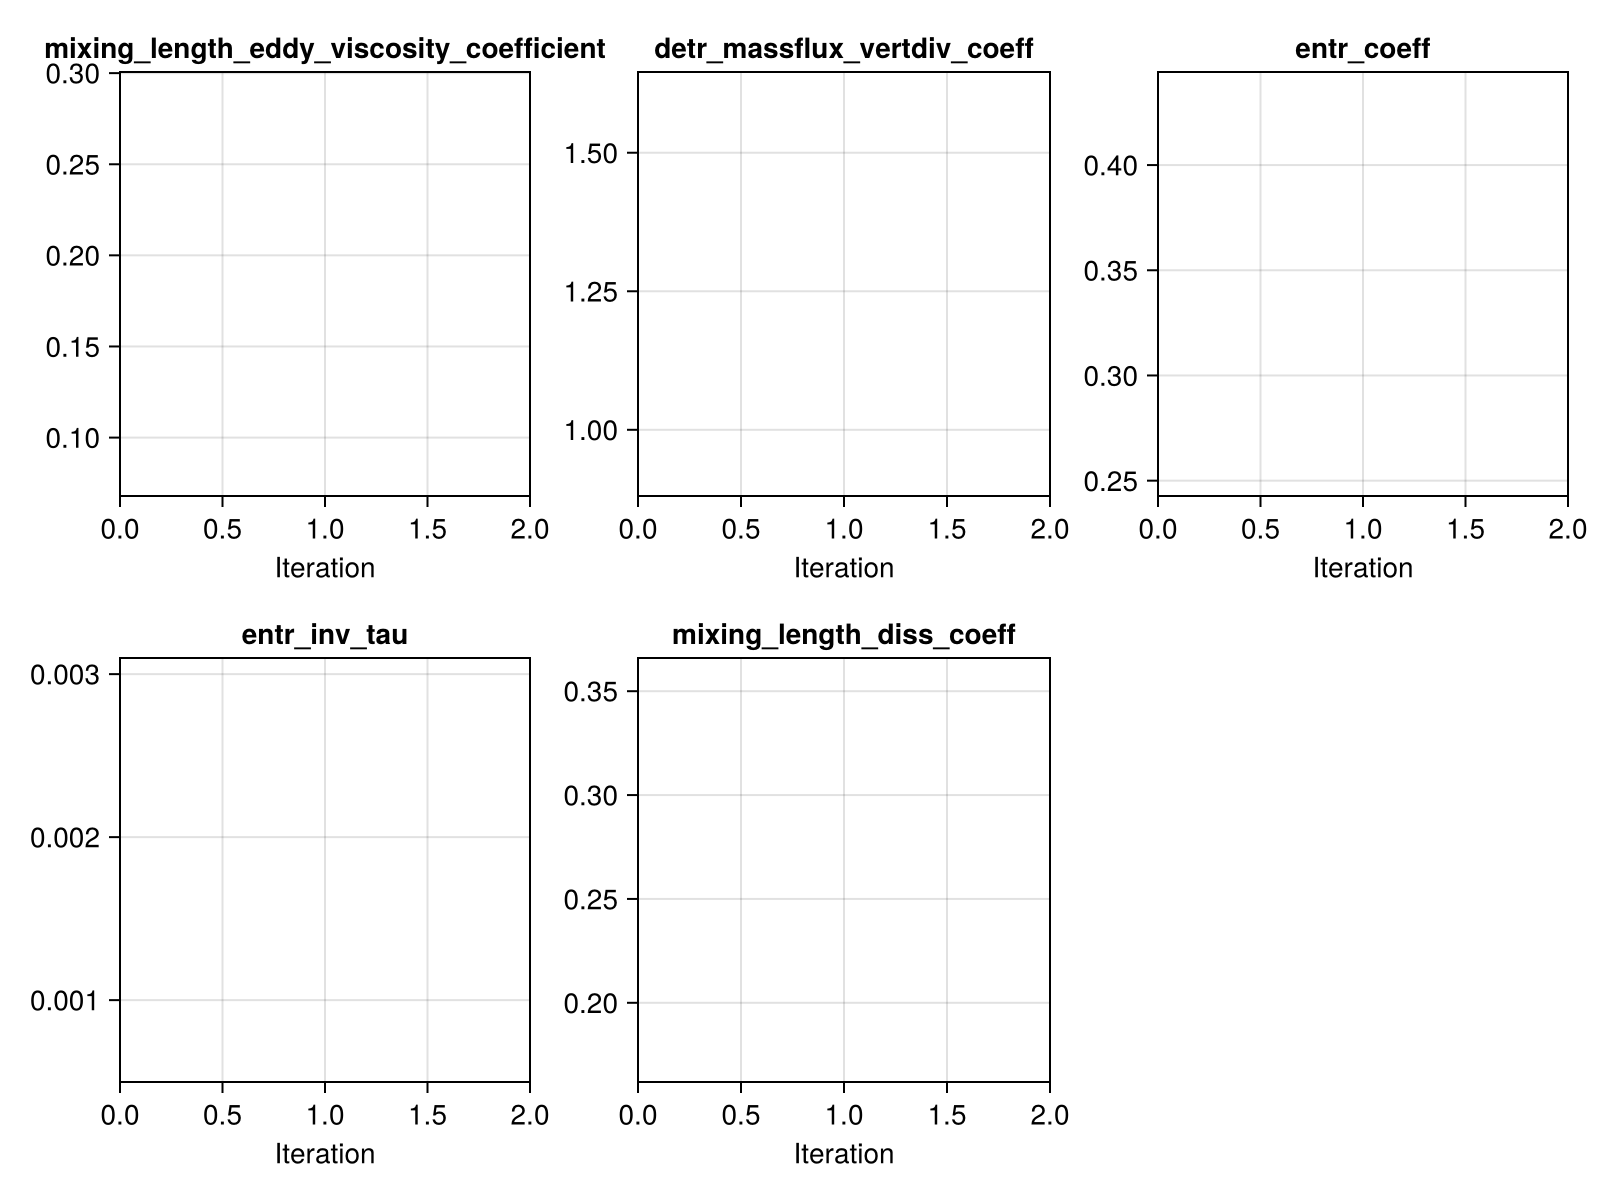

In [2]:
plot_parameters(0, "../output/local_calibration")

In [111]:
# functionalize the 
iteration =4
output_dir = joinpath("../output", "local_calibration")
eki_filepath = joinpath(CAL.path_to_iteration(output_dir, iteration), "eki_file.jld2")
eki = JLD2.load_object(eki_filepath)
loss_vals = EKP.get_g(eki)

4-element Vector{Matrix{Float64}}:
 [405.7190246582031 405.7273864746094 … 405.7123107910156 405.72119140625; 0.36355963349342346 0.361185759305954 … 0.36060988903045654 0.3630284368991852; … ; 273.90545654296875 275.0406188964844 … 270.5113830566406 274.0343933105469; 123.11979675292969 123.1005859375 … 123.07359313964844 123.12283325195312]
 [405.7225646972656 405.72564697265625 … 405.7234191894531 405.7063903808594; 0.3606768250465393 0.3608790636062622 … 0.36042672395706177 0.36103570461273193; … ; 274.0641174316406 275.0635681152344 … 274.0316162109375 264.9486389160156; 123.0937728881836 123.09915161132812 … 123.09363555908203 123.034912109375]
 [405.7287902832031 405.70343017578125 … 405.7229309082031 405.7237548828125; 0.3611186742782593 0.36101865768432617 … 0.3605056703090668 0.36057189106941223; … ; 274.6764831542969 262.8782653808594 … 274.0350646972656 274.0800476074219; 123.09738159179688 123.02073669433594 … 123.09416198730469 123.09424591064453]
 [405.7262878417969 405.

In [104]:
observations = JLD2.load_object("../observations.jld2")

9-element Vector{Float64}:
 405.7465515136719
   0.3578861951828003
   0.004073519725352526
   8.359579086303711
   6.990081601543352e-5
 277.1518249511719
 290.4299011230469
 273.8183898925781
 123.06053924560547

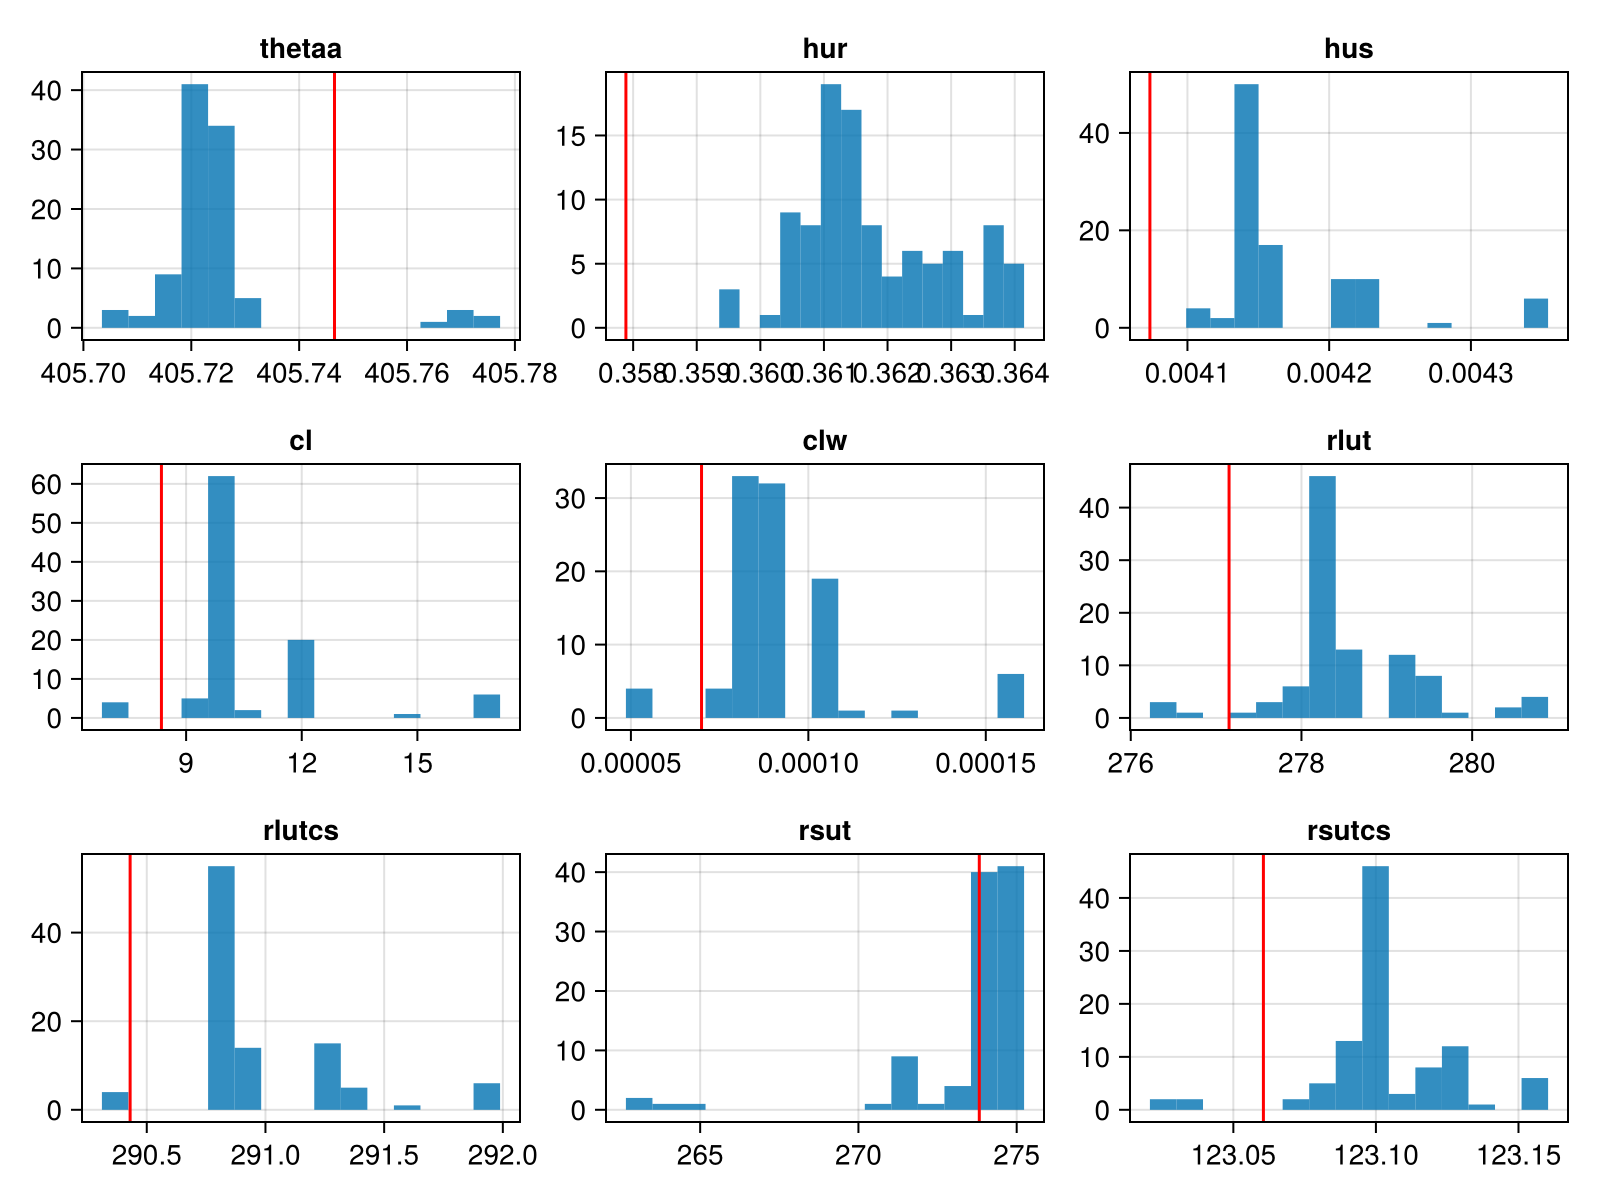

In [112]:
# plot histograms of simulations
var_mat = hcat(loss_vals...)
fig = Figure(size = (800, 600))
num_per_row = 3
for i in 1:9
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1
    
    ax = Axis(fig[row, col], title = config_dict["y_var_names"][i])
    
    hist!(ax, var_mat[i, :])
    vlines!(ax, observations[i], color=:red)
end
fig


In [93]:
function gen_obs(simdir = "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active")
    simdir = SimDir(simdir)
    process_member_data(simdir; y_names = config_dict["y_var_names"], t_start = config_dict["g_t_start_sec"], t_end = config_dict["g_t_end_sec"])
end
observations = gen_obs()
JLD2.save_object("../observations.jld2", observations)

In [97]:
obs_vars = [.3, .036, .00042, 5, 5e-5, 1, 1, 1, 1]

#JLD2.save_object("../obs_noise_cov.jld2", Diagonal(obs_vars))

In [96]:
# load observations 
obs = JLD2.load_object("../observations.jld2")
obs_cov = JLD2.load_object("../obs_noise_cov.jld2")

9×9 Diagonal{Float64, Vector{Float64}}:
 0.0863326   ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅         1.23893   ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅       7.18732e-7   ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅          2.92695      ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅          0.00360234   ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅          4.13139   ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅       2.74378

In [ ]:
# process member data
config_dict = YAML.load_file("../experiment_config.yml")

Dict{Any, Any} with 12 entries:
  "y_var_names"   => ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "r…
  "prior"         => "prior.toml"
  "batch_size"    => 1
  "output_dir"    => "output/local_calibration"
  "g_t_start_sec" => 72000.0
  "g_t_end_sec"   => 144000.0
  "ensemble_size" => 100
  "noise"         => "obs_noise_cov.jld2"
  "observations"  => "observations.jld2"
  "n_iterations"  => 10
  "model_config"  => "model_config.yml"
  "dims"          => 9

In [59]:
simdir = SimDir("../../perf_gcm_driven_scm/output/gcm_driven_scm/output_0010")
process_member_data(simdir; y_names = config_dict["y_var_names"], t_start = config_dict["g_t_start_sec"], t_end = config_dict["g_t_end_sec"])

1-element Vector{Float64}:
 306.3287353515625

SimDir{Dict{Any, Any}, Dict{Any, Any}}("../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active", Dict{Any, Any}("tke" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/tke_10m_inst.nc")), "hus" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/hus_10m_inst.nc")), "rlut" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/rlut_10m_inst.nc")), "rsut" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/rsut_10m_inst.nc")), "thetaa" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/thetaa_10m_inst.nc")), "waup" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/waup_10m_inst.nc")), "detr" => Dict{Any, Any